# Euklidesowy problem komiwojażera
Techniki algorytmiczne

Autorzy: Adrian Panasiewicz & Piotr Gdula

Data: 25.04.2025 r.

Prowadzący: mgr Piotr Stąpor



In [662]:
import pulp as pp
import pandas as pd
import numpy as np
import scipy.spatial as sp
import matplotlib.pyplot as plt
import os, psutil
import math
import time
import itertools
import random

### 1. Generator egzemplarzy danych dla problemu przy podanym jego rozmiarze, (2 x 1 pkt.)

In [663]:
def generate_locations(n, dimensions):
    """Wygenerowanie egzemplarza danych o wielkości danych (n) oraz wymiarze (dimensions)"""
    x = {}
    for i in range(dimensions):
        x.update({f'x_{i}': np.random.randint(0,1000, n)})
    df =  pd.DataFrame(x)
    distances = pd.DataFrame(sp.distance_matrix(df[[*df.columns]].values, df[[*df.columns]].values), index=df.index, columns=df.index)
    return df, distances

### 2. Funkcje pomocnicze

### Wyświetlenie mapy lokalizacji

In [664]:
def plot_locations(df):
    """Wykreślenie położeń miast (df) na wykresie"""
    fig = plt.figure(figsize=(5,5))
    dimensions = len(df.columns)

    # Ustawienie parametrów wykresu w przypadku gdy egzemplarz danuch jest dwuwymiarowy
    if dimensions == 2:
        ax = fig.add_subplot()
        ax.set(
            xlabel='x_0',
            ylabel='x_1',
            xlim = [-100, 1100],
            ylim = [-100, 1100]
        )

    # Ustawienie parametrów wykresu w przypadku gdy egzemplarz danych jest trójwymiarowy
    elif dimensions == 3:
        ax = fig.add_subplot(projection = '3d')
        ax.set(
            xlabel='x_0',
            ylabel='x_1',
            zlabel='x_2',
            xlim = [-100, 1100],
            ylim = [-100, 1100],
            zlim = [-100, 1100]
        )
        ax.set_box_aspect(None, zoom=0.9)

    # Pominięcie wykreślania wykresu przypadku gdy egzemplarz danych ma więcej niż trzy wymiary
    else:
        return
    
    # Naniesienie miast na wykres
    for i, row in df.iterrows():
        if i == 0:
            print(*(row[f'x_{j}'] for j in range(len(row))))
            ax.scatter(*(row[f'x_{j}'] for j in range(len(row))), c='r')
            ax.text(*(row[f'x_{j}']+10 for j in range(len(row))), 'Start')
        else:
            ax.scatter(*(row[f'x_{j}'] for j in range(len(row))), c='black')
            ax.text(*(row[f'x_{j}']+10 for j in range(len(row))), f'{i}')

    ax.grid()
    ax.set_title('Mapa lokalizacji')
    return ax

### Funkcja do wyświetlenie ścieżki

In [665]:
def plot_route(df, route):
    """Wykreślenie ścieżki komiwojażera (route) dla danego położeń miast (df)"""

    # Wykreślenie ścieżki dla dwuwymiarowego egzemplarza danych
    if len(df.columns) == 2:
        ax = plot_locations(df)
        n = len(df)
        
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
        for i, j in route:
            plt.annotate('', xy=[df.iloc[j]['x_0'], df.iloc[j]['x_1']], xytext=[df.iloc[i]['x_0'], df.iloc[i]['x_1']], arrowprops=arrowprops)

    # Wykreślenie ścieżki dla trójwymiarowego egzemplarza danych
    elif len(df.columns) == 3:
        ax = plot_locations(df)
        n = len(df)
    
        for i, j in route:
            lines = []
            arrow_heads = []
            for var_name in df.columns:
                start = [df.iloc[i][col] for col in df.columns]
                end = [df.iloc[j][col] for col in df.columns]
                direction = [e - s for s, e in zip(start, end)]
                ax.quiver(*start, *direction, arrow_length_ratio=0.15, color='blue')
     
    # Pominięcie wykreślania ścieżki, gdy egzemplarz danych ma więcej niż trzy wymiarów 
    else:
        return

    plt.show()

Zapisanie danych do excela

In [666]:
def save_to_excel(solutions_df, file_path):
    """Zapisanie danych do excela"""
    if os.path.exists(file_path):
        base, ext = os.path.splitext(file_path)
        counter = 1
        while True:
            new_file_path = f"{base}({counter}){ext}"
            if not os.path.exists(new_file_path):
                break
            counter += 1
        solutions_df.to_excel(new_file_path, index=False)
    else:
        solutions_df.to_excel(file_path, index=False)

Funkcja do sprawdzenia użycia pamięci przez proces w python

In [667]:
def get_memory_info():
    pid = os.getpid()
    ps = psutil.Process(pid)
    memory_usage = ps.memory_info().rss
    return memory_usage

## 3. Dokładne algorytmy rozwiązujące problem komiwojażera (6 pkt.)

### 3.1. Metoda brute-force rozwiązująca problem komiwojażera

3.1.1. Funkcja generująca wszystkie unikalne permutacje ścieżek, pomijając warianty symetryczne 

In [668]:
def get_filtered_permutations(list_of_choices):
    """Funkcja generująca wszystkie unikalne permutacje ścieżek, pomijając warianty symetryczne 
    na podstawie możliwych miast, do których komiwojażer może się udać (list_of_choices)"""
    # Znalezienie wszystkich permutacji
    all_perms = set(itertools.permutations(list_of_choices))

    # Usunięcie nadmiarowych permutacji
    filtered_perms = set()
    for perm in all_perms:
        if tuple(reversed(perm)) not in filtered_perms:
            filtered_perms.add(perm)
    
    return filtered_perms

3.1.2. Funkcja rozwiązujaca problem metodą brute-force

In [669]:
def brute_force(distance_tensor):
    """Rozwiązanie problemu komiwojażera metodą brute-force na podstawie tensora odległości (distance_tensor)"""
    # Przygotowanie zmiennych do rozwiązania problemu komiwojażera
    t_start = time.perf_counter()
    n = len(distance_tensor.columns)
    choices = range(1,n)
    filtered_perms = get_filtered_permutations(choices)
    best_paths = None
    best_distance = -1

    # Szukanie najkrótszej ścieżki na podstawie możliwych permutacji
    for path in filtered_perms:
        total_distance = 0
        path = [0] + list(path) + [0]
        for i in range(len(path)-1):
            from_city = path[i]
            to_city = path[i+1]
            total_distance  += distance_tensor.loc[from_city,to_city]
        if total_distance < best_distance or best_distance == -1:
            best_distance = total_distance
            best_paths = path

    # Sformatowanie ścieżki, aby ułatwić jej wykreślenie
    formatted_best_path = []
    for i in range(len(best_paths)-1):
        formatted_best_path.append((best_paths[i],best_paths[i+1]))

    # Sprawdzenie obciążenia pamięci
    memory_usage = get_memory_info()

    # Sprawdzenie czasu potrzebnego do wykonannia funkcji brute_force
    duration = time.perf_counter() - t_start

    return formatted_best_path, best_distance, duration, memory_usage

### 3.2. Wykorzystanie gotowej biblioteki impementującej linear programming do rozwiązania problemu

Definicja Miller–Tucker–Zemlin euklidesowego problemu komiwojażera

In [670]:
def integer_programming(distance_tensor):
    """Rozwiązanie problemu komiwojażera metodą linear_programming na podstawie tensora odległości (distance_tensor)"""
    # Przygotowanie zmiennych do rozwiązania problemu komiwojażera
    t_start = time.perf_counter()
    n = len(distance_tensor.columns)
    model = pp.LpProblem("Euklidesowy_problem_komiwojażera", pp.LpMinimize)

    # Stworzenie zmiennych oraz trasy do rozwiązania metody linear programming
    variables = pp.LpVariable.dicts('x', ((i,j) for i in range(n) for j in range(n)), lowBound=0, upBound=1, cat='Binary')
    path = pp.LpVariable.dicts('path', (i for i in range(n)), lowBound=1, upBound=n, cat='Integer')

    # Definicja problemu do zoptymalizowania 
    model += pp.lpSum(distance_tensor[i][j] * variables[i, j] for i in range(n) for j in range(n))

    # Zdefiniowanie ograniczeń - do miasta można tylko raz wejść i wyjść
    for i in range(n):
        model += variables[i,i] == 0
        model += pp.lpSum(variables[i, j] for j in range(n)) == 1
        model += pp.lpSum(variables[j, i] for j in range(n)) == 1

    # Zdefiniowanie ograniczeń - nie można tworzyć podścieżek (subtours)
    for i in range(n):
        for j in range(1,n):
            if i != j and (i != 0 and j != 0):
                model += path[i] - path[j] <= n * (1 - variables[i, j]) - 1
                
    # Rozwiązanie problemu
    status = model.solve()
    status, pp.LpStatus[status], pp.value(model.objective)
    routes = [(i, j) for i in range(n) for j in range(n) if pp.value(variables[i, j]) == 1]

    # Sprawdzenie obciążenia pamięci
    memory_usage = get_memory_info()

    # Sprawdzenie czasu potrzebnego do wykonannia funkcji brute_force
    duration = time.perf_counter() - t_start

    return routes, pp.value(model.objective), duration, memory_usage

# 4. Algorytm genetyczny (aproksymacyjny) rozwiązujący problem TSP (6 pkt.)

Definicja klasy implementującej metody do rozwiązania problemu komiwojażera za pomocą algorytmu genetycznego

In [671]:
class Population:
    def __init__(self, distances):
         self.distances = distances
         self.dimensions = len(distances.columns)
         self.n = len(distances)
         self.population_size = 50 + 2*self.n
         self.specimens = self.generate_random_population()
         self.mutation_probability = 1/(5*self.population_size)

    def calculate_distance(self, path):
        """Metoda do obliczania drogi w danej ścieżce"""
        total_distance = 0
        path = [0] + path + [0]
        for i in range(len(path)-1):
            from_city = path[i]
            to_city = path[i+1]
            total_distance += self.distances.loc[from_city,to_city]
        return total_distance

    def generate_random_population(self):
        """Metoda do generowania losowej populacji"""
        pops = []
        for i in range(self.population_size):
            cities = list(range(1,self.n))
            specimen = []
            while len(cities) > 0:
                city = random.choice(cities)
                cities.remove(city)
                specimen.append(city)
            pops.append([specimen, self.calculate_distance(specimen)])
        return pops
        
    def select_the_most_fit(self):
        """Metoda do wybrania z populacji losowo lepszej części próbek"""
        selected_population = []
        for i in range(math.floor(len(self.specimens)/2)):
            specimen1 = random.choice(self.specimens)
            self.specimens.remove(specimen1)
            specimen2 = random.choice(self.specimens)
            self.specimens.remove(specimen2)
            if specimen1[1] < specimen2[1]:
                selected_population.append(specimen1)
            else:
                selected_population.append(specimen2)
        self.specimens = selected_population

    @staticmethod
    def crossover(parent1_chromosome, parent2):
        """Metoda do dzielenia chromosomów rodziców"""
        crossover_point = random.choice(list(range(len(parent1_chromosome))))
        parent1_chromosome = parent1_chromosome[crossover_point::]
        parent2_chromosome = []
        for i in range(len(parent2)):
            if parent2[i] not in parent1_chromosome:
                parent2_chromosome.append(parent2[i])
        child = parent2_chromosome + parent1_chromosome
        return child


    def mutation(self, child):
        """Metoda do implementacji mutacji"""
        for i in range(len(child)):
            if random.uniform(0,1) < self.mutation_probability:
                mutated_value = random.choice(range(len(child)))
                for j in range(len(child)):
                    if mutated_value == child[j]:
                        child[j] = child[i]
                        child[i] = mutated_value
                        break
        return child
    
    def breed_population(self):
        """Metoda do odnawiania populacji"""
        children = []
        for i in range(len(self.specimens)):
            parent1 = random.choice(self.specimens)
            parent2 = random.choice(self.specimens)
            child = self.crossover(parent1[0], parent2[0])
            child = self.mutation(child)
            children.append([child, self.calculate_distance(child)])
        self.specimens.extend(children)

    def find_the_best(self):
        """Metoda do znalezienia najlepszego rozwiąznia z populacji"""
        best_specimen = [-1,-1]
        for specimen in self.specimens:
            if best_specimen[1] == -1 or specimen[1] < best_specimen[1]:
                best_specimen = specimen
        return best_specimen

    def epoch(self):
        """Metoda do symulacji epoki"""
        self.select_the_most_fit()
        self.breed_population()

Algorytm genetyczny do rozwiązania problemu komiwojażera

In [672]:
def genetic_algorithm(distance_tensor):
    """Rozwiązanie problemu komiwojażera metodą algorytmu genetycznego na podstawie tensora odległości (distance_tensor)"""
    # Pobranie czasu przed rozpoczęciem algorytmu
    t_start = time.perf_counter()

    # Symulacja populacji komiwojażerów
    salesman_population = Population(distances=distance_tensor)
    for epoch_value in range(100):
        salesman_population.epoch()
    solution = salesman_population.find_the_best()
    path = [0] + solution[0] + [0]
    distance = solution[1]

    # Sformatowanie ścieżki, aby ułatwić jej wykreślenie
    formatted_path = []
    for i in range(len(path)-1):
        formatted_path.append((path[i],path[i+1]))

    # Sprawdzenie obciążenia pamięci
    memory_usage = get_memory_info()

    # Sprawdzenie czasu potrzebnego do wykonannia funkcji brute_force
    duration = time.perf_counter() - t_start

    return formatted_path, distance, duration, memory_usage

# 5. Przetestowanie programu dla danych wejściowych o różnym rozmiarze

Porównanie wszystkich metod jednocześnie

C:\Users\adria\AppData\Local\Temp\ipykernel_2996\1161889462.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  solutions_df = pd.concat([solutions_df, pd.DataFrame([data])], ignore_index = True)


12 110


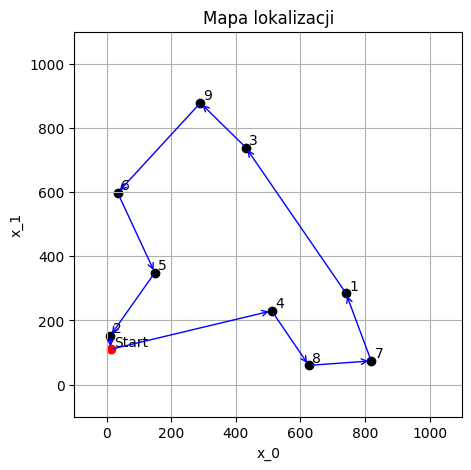

12 110


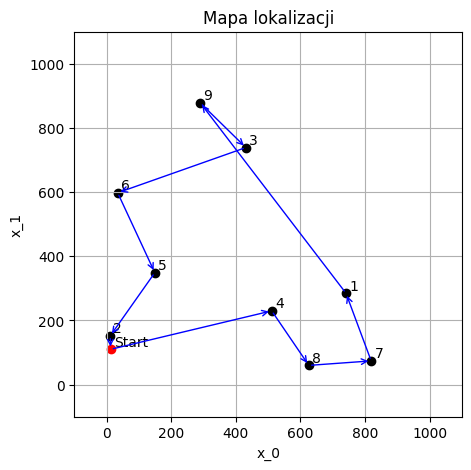

In [673]:
n = 10
dimensions = 2
# BF - Brute force, LP - Linear programming, GA - Genetic algorithm
solutions_df = pd.DataFrame(columns=["Wielkość egzemplarza", 
                                     "Wymiar egzemplarza", 
                                     "Optymalna droga BF", 
                                     "Czas potrzeby na wykonanie metody BF [s]", 
                                     "Pamięć RAM wykorzystana na wykonanie metody BF [Byte]", 
                                     "Optymalna droga LP", 
                                     "Czas na wykonanie metody LP [S]", 
                                     "Pamięć RAM wykorzystana na wykonanie metody LP [Byte]",
                                     "Optymalna droga GA", 
                                     "Czas na wykonanie metody GA [S]", 
                                     "Pamięć RAM wykorzystana na wykonanie metody GA [Byte]",
                                     "Jakość rozwiązania aproksymacyjnego [%]"])

for i in range(2,n+1):
    df, distance_tensor = generate_locations(i,dimensions)
    sol1 = brute_force(distance_tensor)
    sol2 = integer_programming(distance_tensor)
    sol3 = genetic_algorithm(distance_tensor)
    data = {
        "Wielkość egzemplarza": i,
        "Wymiar egzemplarza": dimensions,
        "Optymalna droga BF": sol1[1],
        "Czas potrzeby na wykonanie metody BF [s]": sol1[2],
        "Pamięć RAM wykorzystana na wykonanie metody BF [Byte]": sol1[3],
        "Optymalna droga LP": sol2[1],
        "Czas na wykonanie metody LP [S]": sol2[2],
        "Pamięć RAM wykorzystana na wykonanie metody LP [Byte]": sol2[3],
        "Optymalna droga GA": sol3[1],
        "Czas na wykonanie metody GA [S]": sol3[2],
        "Pamięć RAM wykorzystana na wykonanie metody GA [Byte]": sol3[3],
        "Jakość rozwiązania aproksymacyjnego [%]": sol1[1]/sol3[1]*100
    }
    solutions_df = pd.concat([solutions_df, pd.DataFrame([data])], ignore_index = True)

file_path_all = r"C:\Users\adria\Desktop\TA_all.xlsx"
save_to_excel(solutions_df, file_path_all)

plot_route(df,sol1[0])
plot_route(df,sol3[0])

Przetestowanie algorytmu aproksymacyjnego dla większych egzemplarzy wejściowych

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
981 861


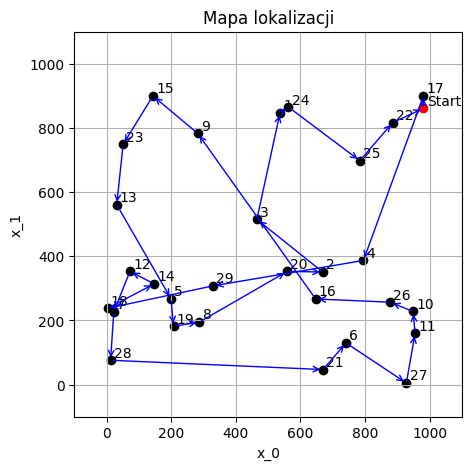

In [ ]:
n = 30
dimensions = 2

aprox_df = pd.DataFrame(columns=["Wielkość egzemplarza", 
                                     "Wymiar egzemplarza", 
                                     "Optymalna droga BF", 
                                     "Pamięć RAM wykorzystana na wykonanie metody GA [Byte]", 
                                     "Optymalna droga GA", "Czas na wykonanie metody GA [S]", 
                                     "Pamięć RAM wykorzystana na wykonanie metody GA [Byte]",])

for i in range(2,n+1):
    df, distance_tensor = generate_locations(i,dimensions)
    sol = genetic_algorithm(distance_tensor)
    data = {
        "Wielkość egzemplarza": i,
        "Wymiar egzemplarza": dimensions,
        "Optymalna droga GA": sol[1],
        "Czas na wykonanie metody GA [S]": sol[2],
        "Pamięć RAM wykorzystana na wykonanie metody GA [Byte]": sol[3]
    }
    solutions_df = pd.concat([solutions_df, pd.DataFrame([data])], ignore_index = True)


file_path_aprox = r"C:\Users\adria\Desktop\TA_aprox.xlsx"
save_to_excel(aprox_df, file_path_aprox)
plot_route(df,sol[0])